# Rules

In [ ]:
#| default_exp rules
%load_ext autoreload
%autoreload 2

### Overview
Up until now, we've covered the parsing and matching phases of graph transformation. The user provides specifications for 3 NetworkX graphs which, when combined, denote a single **rule** of graph transformation:

1. **LHS** - A **pattern** graph which is searched in the input graph; For each match, we apply the transformation. Previous notebooks handled the way we use LHS Graphs to find matches in the graph.

2. **P** (optional) - Denotes the parts of the pattern which we want to **preserve** during the transformation. Nodes, edges and attributes that we want to preserve from LHS appear in P as well; Anything that appears in the input graph but not in P is thus removed during the transformation. 
    - When combined with LHS, P can also denote the **cloning** of LHS nodes. In the context of this library, the cloning of a LHS node $n$ is the creation of a new node (that appears in P) which has the same attributes as $n$, and whose edges are clones of the edges connected to $n$ in LHS.

3. **RHS** (optional) - Denotes the **interface of the graph after the transformation**. As a result, we can infer from it the nodes, edges and attributes that we add to the preserved parts, resulting in the final transformation. Nodes, edges and attributes that appear in RHS but not in P are added.
    - When combined with P, RHS can also denote the **merging** of P nodes. In the context of this library, the merging of P nodes $x_1, ..., x_k$ is the creation of a new node (that appears in RHS) whose attributes and edges are the merge of the corresponding components in $x_1,...,x_k$.

The following module defines the **Rule** class which, given these three graphs, allows finding the nodes/edges/attribute to add/remove/clone/merge as dictated by the rule. These findings will be used in the final module, which will finally execute the transformation itself.

### Requirements

In [ ]:
#| export
from typing import *
from networkx import DiGraph

from graph_rewrite.core import GraphRewriteException, NodeName, EdgeName, _create_graph, _plot_graph
from graph_rewrite.match_class import *

### Merge Policy
One of the features our rules allow is merging nodes. Nodes which appear in P are merged into new RHS nodes, along with their attributes. This might cause an ambiguity when merging P nodes which share one or more attributes with the same name (but different values) - What should be the value of that attribute in the new merged RHS node?

We offer two optional behaviors - policies for solving this conflict:
1. **choose_last** (default) - if the merged nodes with the shared attribute are $x_1,...,x_n$, then the value of the attribute in the merged node will be that of $x_n$.
2. **union** - if the merged node with the shared attribute are $x_1,...,x_n$, with the attribute values $v_1,...,v_n$ respectively, then the value of the attribute in the merged node will be $set(v_1,...,v_n)$.

In [ ]:
#| export
class MergePolicy:
    """Static class for policies for solving conflicts when merging nodes with shared attributes.
    """
    @staticmethod
    def _merge_wrapper(dict1: dict, dict2: dict, collision_policy: Callable[[Any, Any], Any]) -> dict:
        """A generic dictionary merger, which solves conflicts with a given collision policy.

        Args:
            dict1 (dict): A dictionary
            dict2 (dict): A dictionary
            collision_policy (Callable[[Any, Any], Any]): A function that recieves two values and returns a new value (for solving the conflict).

        Returns:
            dict: The merged dictionary according to the collision policy.
        """
        merged = {}
        for key in dict1.keys():
            if key in dict2.keys():
                merged[key] = collision_policy(dict1[key], dict2[key])
            else:
                merged[key] = dict1[key]
        for key in dict2.keys():
            if key not in dict1.keys():
                merged[key] = dict2[key]
        return merged
    
    @staticmethod
    def choose_last(dict1: dict, dict2: dict) -> dict:
        """Merge two dictionaries, such that for each attribute x they share, its merged value is dict2[x].

        Args:
            dict1 (dict): A dictionary
            dict2 (dict): A dictionary

        Returns:
            dict: The merged dictionary
        """
        return MergePolicy._merge_wrapper(dict1, dict2, lambda v1, v2: v2)
    
    @staticmethod
    def union(dict1: dict, dict2: dict) -> dict:
        """Merge two dictionaries, such that for each attributbe x they share, its merged value is a set that contains both dict1[x] and dict2[x].

        Args:
            dict1 (dict): A dictionary
            dict2 (dict): A dictionary

        Returns:
            dict: The merged dictionary.
        """
        return MergePolicy._merge_wrapper(dict1, dict2, 
                                           lambda v1, v2: set([v1, v2]))

### Rules Definition
The following is the complete definition of the Rule class (and the exceptions it might raise).

In [ ]:
#| export
exceptions = {
    "clone_non_existing": lambda p_node, lhs_node: f"Node {p_node} clones an non-existing node {lhs_node}.",
    "clone_illegal_id": lambda p_node, copy_num: f"Node {p_node} clone id {copy_num} is illegal.",
    "p_bad_format": lambda p_node: f"Node {p_node} has a bad formatted name.",
    "p_not_in_lhs": lambda p_node: f"Node {p_node} in P does not exist in LHS.",
    "p_edge_not_in_lhs": lambda p_s, p_t: f"Edge {(p_s, p_t)} in P does not exist (and doesn't clone any edge) in LHS.",
    "rhs_illegal_name": lambda rhs_node: f"Node {rhs_node} merges at least one non-existing P node.",
    "rhs_not_in_p": lambda p_node: f"Node {p_node} in P does not exist in RHS, nor merges into an RHS node.",
    "add_attrs_in_p_node": lambda p_node: f"P node {p_node} cannot add attributes.",
    "add_attrs_in_p_edge": lambda s_copy, t_copy: f"P edge ({s_copy},{t_copy}) cannot add attributes.",
    "remove_attrs_in_rhs_node": lambda rhs_node: f"RHS node {rhs_node} cannot remove attributes.",
    "remove_attrs_in_rhs_edge": lambda s, t: f"RHS edge ({s},{t}) cannot remove attributes.",
    "attrs_in_cloned_node": lambda p_node: f"Cloned node {p_node} in P should not explicitly mention attributes",
    "attrs_in_cloned_edge": lambda s_copy, t_copy: f"Cloned edge ({s_copy},{t_copy}) in P should not explicitly mention attributes"
}

In [ ]:
#| export
class Rule:
    global exceptions
    """A transformation rule, defined by 1-3 graphs:
    - LHS - defines the pattern to search for in the graph.
    - P - defines what parts to preserve (and also defines clones).
    - RHS - defines what parts to add (and also defines merges).
    """
    def __init__(self, lhs: DiGraph, p: DiGraph = None, rhs: DiGraph = None, merge_policy = MergePolicy.choose_last):
        self.lhs = lhs
        self.p = p if p else self.lhs.copy()
        self.rhs = rhs if rhs else self.p.copy()
        self.merge_policy = merge_policy

        self._p_to_lhs, self._p_to_rhs = {}, {}
        self._merge_sym, self._clone_sym = '&', '*'
        self._create_p_lhs_hom()
        self._create_p_rhs_hom()

        self._rev_p_lhs = self._reversed_dictionary(self._p_to_lhs)
        self._rev_p_rhs = self._reversed_dictionary(self._p_to_rhs)
        self._validate_rule()

    # Utils
    def _create_p_lhs_hom(self):
        """Construct the homomorphism from P to LHS based on the rule.
        Handles cloned nodes.
        """
        for p_node in self.p.nodes():
            if self._clone_sym in str(p_node):
                if len(str(p_node).split(self._clone_sym)) == 2:
                    lhs_node, copy_num = str(p_node).split(self._clone_sym)
                    if lhs_node not in self.lhs.nodes():
                        raise GraphRewriteException(exceptions["clone_non_existing"](p_node, lhs_node))
                    elif not copy_num.isnumeric():
                        raise GraphRewriteException(exceptions["clone_illegal_id"](p_node, copy_num))
                    else:
                        self._p_to_lhs[p_node] = lhs_node
                else:
                    raise GraphRewriteException(exceptions["p_bad_format"](p_node))
            elif p_node in self.lhs.nodes():
                self._p_to_lhs[p_node] = p_node
            else:
                raise GraphRewriteException(exceptions["p_not_in_lhs"](p_node))

    def _create_p_rhs_hom(self):
        """Construct the homomorphism from P to RHS based on the rule.
        Handles merged nodes.
        """
        for rhs_node in self.rhs.nodes():
            if self._merge_sym in str(rhs_node):
                if len(str(rhs_node).split(self._merge_sym)) > 1:
                    p_nodes = str(rhs_node).split(self._merge_sym)
                    if all([p_node in self.p.nodes() for p_node in p_nodes]):
                        for p_node in p_nodes:
                            self._p_to_rhs[p_node] = rhs_node
                    else:
                        raise GraphRewriteException(exceptions["rhs_illegal_name"](rhs_node))
        for p_node in self.p.nodes():
            if p_node not in self._p_to_rhs.keys():
                if p_node in self.rhs.nodes():
                    self._p_to_rhs[p_node] = p_node
                else:
                    raise GraphRewriteException(exceptions["rhs_not_in_p"](p_node))

    def _reversed_dictionary(self, dictionary: dict) -> dict[Any, set]:
        """Given a dictionary, return a dictionary which maps every
        value from the original dictionary to the set of keys 
        that are mapped to it.

        E.g., for {1: 'a', 2: 'a', 3: 'b'}, the reversing function
        returns {'a': {1,2}, 'b': {3}}.

        Args:
            dictionary (dict): A dictionary to reverse

        Returns:
            dict[Any, set]: A reversed dictionary as described
        """
        rev_dict: dict[Any, set] = {}
        for key, value in dictionary.items():
            if value not in rev_dict:
                rev_dict[value] = set()
            rev_dict[value].add(key)
        return rev_dict

    def _get_value_safe(self, dictionary: dict[Any, set], key) -> set:
        """A wrapper for accessing a key in a dictionary, which returns an empty set if the key
        does not exist (useful for our purposes).

        Args:
            dictionary (dict[Any, set]): A dictionary
            key (_type_): A key to access

        Returns:
            set: The set mapped by the key in the dictionary, or an empty set if the key does not exist in the dictionary.
        """
        return dictionary[key] if key in dictionary else set()

    def _dict_difference(self, target: dict, other: dict) -> dict:
        """Given two dictionaries, create a new dictionary which "subtracts" the other dictionary from the target one:
        For each key in target, if it does not appear in the other dictionary, or appears there with a different value,
        then we map the key to the target value in the new dictionary. Otherwise, the key is not included in the new dictionary.

        Args:
            target (dict): A dictionary
            other (dict): A dictionary to subtract from target

        Returns:
            dict: The difference dictionary as explained
        """
        new_dict = {}
        for key in target:
            if key in other and target[key] != other[key]:
                new_dict[key] = target[key]
            elif key not in other:
                new_dict[key] = target[key]
        return new_dict

    def _validate_lhs_p(self):
        """Validates the LHS->P homomorphism, and raises appropriate exceptions if it's invalid.
        """

        # Nodes in P do NOT add attributes that aren't in the corresponding LHS node(s).
        for node_lhs in self.lhs.nodes():
            lhs_attrs = set(self.lhs.nodes(data=True)[node_lhs].keys())
            p_copies = self._get_value_safe(self._rev_p_lhs, node_lhs)
            for node_p in p_copies:
                p_attrs = set(self.p.nodes(data=True)[node_p].keys())
                if not p_attrs.issubset(lhs_attrs):
                    raise GraphRewriteException(exceptions["add_attrs_in_p_node"](node_p))
        
        # Edges in P do NOT add attributes that aren't in the corresponding LHS edge(s).
        for s, t in self.lhs.edges():
            rhs_attrs = set(self.lhs.get_edge_data(s, t).keys())
            s_copies, t_copies = self._get_value_safe(self._rev_p_lhs, s), self._get_value_safe(self._rev_p_lhs, t)
            for s_copy in s_copies:
                for t_copy in t_copies:
                    # For each "clone of edge (s, t)" that is in P
                    if (s_copy, t_copy) in self.p.edges():
                        p_attrs = set(self.p.get_edge_data(s_copy, t_copy).keys())
                        if not p_attrs.issubset(rhs_attrs):
                            raise GraphRewriteException(exceptions["add_attrs_in_p_edge"](s_copy, t_copy))
                        
        # Edges in P must have a corresponding LHS edge
        for p_s, p_t in self.p.edges():
            if (self._p_to_lhs[p_s], self._p_to_lhs[p_t]) not in self.lhs.edges():
                raise GraphRewriteException(exceptions["p_edge_not_in_lhs"](p_s, p_t))

    def _validate_rhs_p(self):
        """Validates the RHS->P homomorphism, and raises appropriate exceptions if it's invalid.
        """

        # Nodes in RHS do NOT remove attributes that are in the corresponding P node(s).
        # Note that we ignore merged nodes here (which follow this rule automatically).
        for node_rhs in self.rhs.nodes():
            if node_rhs not in self.nodes_to_merge().keys():
                rhs_attrs = set(self.rhs.nodes(data=True)[node_rhs].keys())
                p_origins = self._get_value_safe(self._rev_p_rhs, node_rhs)
                for node_p in p_origins:
                    p_attrs = set(self.p.nodes(data=True)[node_p].keys())
                    if not p_attrs.issubset(rhs_attrs):
                        raise GraphRewriteException(exceptions["remove_attrs_in_rhs_node"](node_rhs))
        
        # Edges in RHS do NOT remove attributes that are in the corresponding P edge(s).
        # Note that we ignore edges created by a merge here (they follow this rule automatically).
        for s, t in self.rhs.edges():
            if s not in self.nodes_to_merge().keys() and t not in self.nodes_to_merge().keys():
                rhs_attrs = set(self.rhs.get_edge_data(s, t).keys())
                s_origins, t_origins = self._get_value_safe(self._rev_p_rhs, s), self._get_value_safe(self._rev_p_rhs, t)
                for s_origin in s_origins:
                    for t_origin in t_origins:
                        if (s_origin, t_origin) in self.p.edges():
                            origin_attrs = set(self.p.get_edge_data(s_origin, t_origin).keys())
                            if not origin_attrs.issubset(rhs_attrs):
                                raise GraphRewriteException(exceptions["remove_attrs_in_rhs_edge"](s,t))

    def _validate_rule(self):
        """Validates the rule - that is, checking that the homomorphisms are valid, and that clones mentioned in the rule
        are valid (if any exist).
        """

        self._validate_lhs_p()
        self._validate_rhs_p()
        
        clones = {item for clones_list in self.nodes_to_clone().values() for item in clones_list}
        # validate cloned nodes in P have no attributes mentioned (all attributes are copied automatically)
        for clone in clones:
            if self.p.nodes(data=True)[clone] != {}:
                raise GraphRewriteException(exceptions["attrs_in_cloned_node"](clone))
        
        # validate cloned edges in P (edges with cloned endpoint) have no attributes mentioned
        for s, t, attrs in self.p.edges(data=True):
            if (s in clones or t in clones) and attrs != {}:
                raise GraphRewriteException(exceptions["attrs_in_cloned_edge"](s, t))

    def _merge_node_attrs(self, rhs_node: NodeName, p_origins: list[NodeName]) -> dict:
        """Given a node in RHS that is a copy / a merge of one or more nodes in P,
        and the P nodes which it copies / merges, returns the dictionary of new attributes
        added to the merged node in RHS (That is, not including the attributes which stem from the merge, other than merged attributes which were overriden in RHS).

        Args:
            rhs_node (NodeName): A node in RHS
            p_origins (list[NodeName]): A list of P nodes which rhs_node merges.

        Returns:
            dict: A dictionary of added attributes (keys and values) of the merged RHS node.
        """
        merge_rhs_attrs = {}
        for p_origin in p_origins:
            new_rhs_attrs = self._dict_difference(self.rhs.nodes[rhs_node], self.p.nodes[p_origin])
            merge_rhs_attrs = self.merge_policy(merge_rhs_attrs, new_rhs_attrs)
        return merge_rhs_attrs

    def _merge_edge_attrs(self, rhs_edge: EdgeName, s_origins: list[NodeName], t_origins: list[NodeName]) -> dict:
        """Given an edge in RHS that is possibly a copy / a merge of one or more edges,
        and the copies / merges of both its endpoints, returns the dictionary of new attributes
        added to the merged edge in RHS (That is, not including the attributes which stem from the merge, other than merged attributes which were overriden in RHS).

        Args:
            rhs_edge (EdgeName): An edge in RHS
            s_origins (list[NodeName]): A list of P nodes which the source endpoint of the edge merges.
            t_origins (list[NodeName]): A list of P nodes which the target endpoint of the edge merges.

        Returns:
            dict: A dictionary of added attributes (keys and values) of the merged RHS edge.
        """
        merge_rhs_attrs = {}
        for s_origin in s_origins:
            for t_origin in t_origins:
                if (s_origin, t_origin) in self.p.edges():
                    new_rhs_attrs = self._dict_difference(
                        self.rhs.get_edge_data(*rhs_edge),
                        self.p.get_edge_data(s_origin, t_origin)
                    )
                    merge_rhs_attrs = self.merge_policy(merge_rhs_attrs, new_rhs_attrs)
        return merge_rhs_attrs

    # The following functions are presented in the order of transformation.
    def nodes_to_clone(self) -> dict[NodeName, set[NodeName]]:
        """Find all LHS nodes that should be cloned in P, and for each node, find all its P clones.

        Returns:
            dict[NodeName, set[NodeName]]:
                A dictionary which maps each cloned node in LHS to a set
                of all nodes in P which are its clones.
        """

        # Find all LHS nodes which are mapped by more than one node in P (in the P->LHS Hom.)
        return {lhs_node: self._rev_p_lhs[lhs_node] for lhs_node in self.lhs.nodes() \
                            if len(self._get_value_safe(self._rev_p_lhs, lhs_node)) > 1}

    def nodes_to_remove(self) -> set[NodeName]:
        """Find all LHS nodes that should be removed.

        Returns:
            set[NodeName]: Nodes in LHS which should be removed.
        """

        # Find all LHS nodes which are not mapped by any node in P (in the P->LHS Hom.)
        return {lhs_node for lhs_node in self.lhs.nodes() if len(self._get_value_safe(self._rev_p_lhs, lhs_node)) == 0}

    def edges_to_remove(self) -> set[EdgeName]:
        """Find all P edges that should be removed.

        Note: Does not include edges which one of their endpoints was removed by the rule,
        as during transformation, we begin by removing all removed nodes along with the connected edges.

        Returns:
            set[EdgeName]: Edges in P which should be removed.
        """
        edges_to_remove = set()
        for s, t in self.lhs.edges():
            # If one of the edge endpoints was removed, the edge was removed automatically so we skip it here
            if s not in self.nodes_to_remove() and t not in self.nodes_to_remove():
                s_copies, t_copies = self._get_value_safe(self._rev_p_lhs, s), self._get_value_safe(self._rev_p_lhs, t)
                for s_copy in s_copies:
                    for t_copy in t_copies:
                        # For each "clone of edge (s,t)" that shouldn't be in P, remove it
                        if (s_copy, t_copy) not in self.p.edges():
                            edges_to_remove.add((s_copy, t_copy))
        return edges_to_remove

    def node_attrs_to_remove(self) -> dict[NodeName, set]:
        """For each P node, find all attributes of its corresponding LHS node
        which should be removed from it in P.

        Returns:
            dict[NodeName, set]: A dictionary from P nodes to attributes that should be
                removed from their corresponding LHS nodes.
        """
        attrs_to_remove = {}
        for node_lhs in self.lhs.nodes():
            if node_lhs not in self.nodes_to_clone().keys(): # cloned nodes do not remove attrs
                p_copies = self._get_value_safe(self._rev_p_lhs, node_lhs)
                for node_p in p_copies:
                    # Find all attributes that are in the LHS node but not in the new P node
                    diff_attrs = set(self._dict_difference(
                        self.lhs.nodes[node_lhs],
                        self.p.nodes[node_p]
                    ).keys())
                    if len(diff_attrs) != 0:
                        # Remove all such attributes from the P node
                        attrs_to_remove[node_p] = diff_attrs
        return attrs_to_remove

    def edge_attrs_to_remove(self) -> dict[EdgeName, set]:
        """For each P edge, find all attributes of its corresponding LHS edge
        which should be removed from it in P.

        Returns:
            dict[EdgeName, set]: A dictionary from P edges to attributes that should be
                removed from their corresponding LHS edges.
        """
        attrs_to_remove = {}
        for s, t in self.lhs.edges():
            s_copies, t_copies = self._get_value_safe(self._rev_p_lhs, s), self._get_value_safe(self._rev_p_lhs, t)
            for s_copy in s_copies:
                for t_copy in t_copies:
                    # For each "clone of edge (s, t)" that is in P
                    if (s_copy, t_copy) in self.p.edges():
                        diff_attrs = set(self._dict_difference(
                            self.lhs.get_edge_data(s,t),
                            self.p.get_edge_data(s_copy, t_copy)
                        ).keys())
                        if len(diff_attrs) != 0:
                            # Remove all such attributes
                            attrs_to_remove[(s_copy, t_copy)] = diff_attrs
        return attrs_to_remove

    def nodes_to_merge(self) -> dict[NodeName, set[NodeName]]:
        """Find all RHS nodes which are a merge of nodes in P, and for each node, find all P nodes that merge into it.

        Returns:
            dict[NodeName, set[NodeName]]: 
                A dictionary which maps each node in RHS that is a merge of P nodes,
                to a set of nodes in P which it merges.
        """

        # Find all RHS nodes that are mapped by more than one node in P (in the P->RHS Hom.)
        return {rhs_node: self._rev_p_rhs[rhs_node] for rhs_node in self.rhs.nodes() \
                            if len(self._get_value_safe(self._rev_p_rhs, rhs_node)) > 1}

    def nodes_to_add(self) -> set[NodeName]:
        """Find all RHS nodes which should be added.

        Note: Does not include nodes in RHS that are created as a merge of P nodes.

        Returns:
            set[NodeName]: Nodes which should be added to RHS.
        """

        # Find all RHS nodes which are not mapped by any node in P (in the P->RHS Hom.)
        return {rhs_node for rhs_node in self.rhs.nodes() if len(self._get_value_safe(self._rev_p_rhs, rhs_node)) == 0}

    def edges_to_add(self) -> set[EdgeName]:
        """Find all RHS edges that should be added. 

        Note: Does not include edges added to merged nodes.

        Returns:
            set[EdgeName]: Edges which should be added to RHS.
        """
        edges_to_add = set()
        for s, t in self.rhs.edges():
            # New edges from at least one new node (not including merged nodes)
            if s in self.nodes_to_add() or t in self.nodes_to_add():
                edges_to_add.add((s,t)) # surely a new edge
            else:
                s_origins, t_origins = self._get_value_safe(self._rev_p_rhs, s), self._get_value_safe(self._rev_p_rhs, t)
                # New edges from existing P nodes
                if all([(s_origin, t_origin) not in self.p.edges() for s_origin in s_origins for t_origin in t_origins]):
                    edges_to_add.add((s,t))
        return edges_to_add

    def node_attrs_to_add(self) -> dict[NodeName, dict]:
        """For each RHS node, find all attributes (and values) of its corresponding P node(s)
        which should be added to the RHS node.
        
        Returns:
            dict[NodeName, dict]: A dictionary that maps RHS nodes to their added attributes and values.
        """
        attrs_to_add = {}
        for node_rhs in self.rhs.nodes():
            if node_rhs in self.nodes_to_add():
                rhs_attrs = self.rhs.nodes(data=True)[node_rhs]
                if len(rhs_attrs) != 0:
                    attrs_to_add[node_rhs] = rhs_attrs
            else:
                p_origins = self._get_value_safe(self._rev_p_rhs, node_rhs)
                merged_p_attrs = self._merge_node_attrs(node_rhs, p_origins)
                if len(merged_p_attrs) != 0:
                    attrs_to_add[node_rhs] = merged_p_attrs
        return attrs_to_add

    def edge_attrs_to_add(self) -> dict[EdgeName, dict]:
        """For each RHS edge, find all attributes (and values) of its corresponding P edge(s)
        which should be added to the RHS edge.

        Returns:
            dict[EdgeName, dict]: A dictionary that maps RHS edges to their added attributes and values.
        """
        attrs_to_add = {}
        for s, t in self.rhs.edges():
            if s in self.nodes_to_add() or t in self.nodes_to_add():
                rhs_attrs = self.rhs.get_edge_data(s, t)
                if len(rhs_attrs) != 0:
                    attrs_to_add[(s, t)] = rhs_attrs
            else:
                s_origins, t_origins = self._get_value_safe(self._rev_p_rhs, s), self._get_value_safe(self._rev_p_rhs, t)
                merged_p_attrs = self._merge_edge_attrs((s, t), s_origins, t_origins)
                if len(merged_p_attrs) != 0:
                    attrs_to_add[(s, t)] = merged_p_attrs
        return attrs_to_add


### Tests and Examples
The following section overviews the different use cases of graph transformation, and the rules that the user should construct in order to execute them. Before we dive in, here are some test utilities:

#### Test Utils

In [ ]:
def _assert_rule(lhs: DiGraph, p: DiGraph = None, rhs: DiGraph = None, merge_policy = MergePolicy.choose_last,
                 error: str = None,
                 nodes_clone: dict[NodeName, set[NodeName]] = {},
                 nodes_remove: set[NodeName] = set(),
                 edges_remove: set[EdgeName] = set(),
                 node_attrs_remove: dict[NodeName, set] = {}, 
                 edge_attrs_remove: dict[EdgeName, set] = {}, 
                 nodes_merge: dict[NodeName, set[NodeName]] = {}, 
                 nodes_add: set[NodeName] = set(), 
                 edges_add: set[EdgeName] = set(),
                 node_attrs_add: dict[NodeName, dict] = {}, 
                 edge_attrs_add: dict[EdgeName, dict] = {}):
    try:
        rule = Rule(lhs, p=p, rhs=rhs, merge_policy=merge_policy)
        assert rule.nodes_to_clone() == nodes_clone
        assert rule.nodes_to_remove() == nodes_remove
        assert rule.edges_to_remove() == edges_remove
        assert rule.node_attrs_to_remove() == node_attrs_remove
        assert rule.edge_attrs_to_remove() == edge_attrs_remove
        assert rule.nodes_to_merge() == nodes_merge
        assert rule.nodes_to_add() == nodes_add
        assert rule.edges_to_add() == edges_add
        assert rule.node_attrs_to_add() == node_attrs_add
        assert rule.edge_attrs_to_add() == edge_attrs_add
        assert error == None
    except GraphRewriteException as e:
        assert e.message == error

#### Preserve and Remove (Without Attributes)

We begin by defining a simple LHS graph, a pattern without attributes at all:

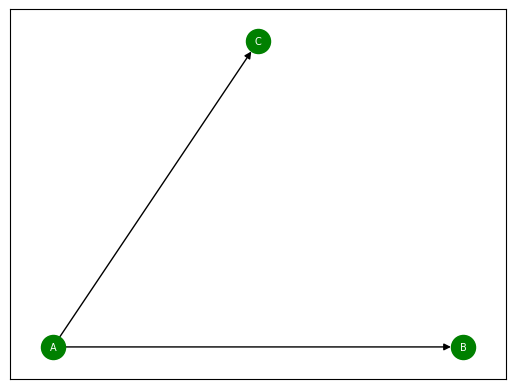

In [ ]:
lhs = _create_graph(['A', 'B', 'C'], [('A','B'), ('A','C')])
_plot_graph(lhs)

If we construct a rule without specifing P, then P defaults to a copy of LHS. If we don't specify RHS, then RHS defaults to a copy of P.
That is, when constructing a rule without P or LHS, we preserve everything from LHS (P contains all LHS elements) and add nothing (no difference between P and RHS), or in other words - a rule which does not change a thing.

In [ ]:
_assert_rule(lhs)

As explained above, P defines which parts of the LHS we want to preserve in the transformation. Therefore, if something from LHS is missing in P, the rule infers that it should remove it.

For example, if P contains all nodes of LHS but none of its edges, the rule marks all LHS edges as edges to remove:

In [ ]:
p = _create_graph(['A', 'B', 'C'], [])
_assert_rule(lhs, p=p, edges_remove={('A','B'), ('A','C')})

Surely, we can remove nodes in the same way. Note that when the transformation module removes a node, it also removes all the edges that are connected to it. Since in the transformation the removal of nodes is done before the removal of edges, whenever the rule finds a node that should be removed, it assumes (correctly) that the connected edges will be removed automatically and therefore, does not mark the connected edges as edges to remove.

Here, the P graph is missing node $A$ (that is connected to edges $(A,B), (A,C)$) as well as all edges in LHS (which are coincidentely exactly the edges connected to $A$). Therefore, while the transformation results in the removal of these edges as well, the rule only marks the node for removal:

In [ ]:
p = _create_graph(['B', 'C'], [])
_assert_rule(lhs, p=p, nodes_remove={'A'})

However, if $P$ does not contain node $B$ and all edges of the graph, edge $(A,B)$ isn't marked for removal (automatically removed along with node $B$), while edge $(A,C)$ is marked for removal:

In [ ]:
p = _create_graph(['A','C'], [])
_assert_rule(lhs, p=p, nodes_remove={'B'}, edges_remove={('A','C')})

#### Clone Nodes

As explained in the beginning of this notebook, the combination of LHS and P allows **cloning** nodes. 

Assume that we want to clone an LHS node called $x$. In the P graph, we add a new node called $x*n$, where $n$ is some integer of the user's choosing that is destined to denote a unique number of the copy, and thus allows mutiple clones (though this notion of the copy number is not enforced by the library). 

A P node with such a name is automatically inferred to be a clone of the LHS node $x$ (if no such node exists, an exception is raised), and the transformation module will clone its edges and attributes as expected.
The Rule class identifies P nodes that are clones of LHS nodes, and creates a dictionary that maps LHS nodes to a set of its P clones (if there are any). The edges and attributes that are added by the cloning are not counted as added edges and attributes; The cloned node is not counted as an added node, but rather as a cloned one.

Assume that we want to have 2 clones of node $C$ in P, named $C*1, C*2$ respectively. In LHS, node $C$ is connected to edge $(A,C)$; Therefore, the cloning process will add $C*1, C*2, (A,C*1)$ and $(A,C*2)$:

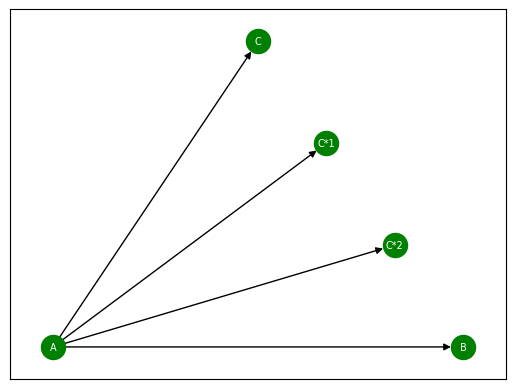

In [ ]:
p = _create_graph(['A', 'B', 'C', 'C*1', 'C*2'], [('A','B'), ('A','C'), ('A','C*1'), ('A', 'C*2')])
_plot_graph(p)
_assert_rule(lhs, p=p, nodes_clone={'C': {'C', 'C*1', 'C*2'}})

Note that in this example, we kept $C$ in the P graph, and it was counted as a clone of the LHS node $C$. If we decided to not keep $C$ in the P graph, we can not mention it (and its connected edges) in P. Note that in such a case, the rule does not count $C$ as a removed node or $(A,C)$ as a removed edge: As far as the rule is concerned, the P version of $C$ is just a clone of LHS'S $C$ which we didn't create here.

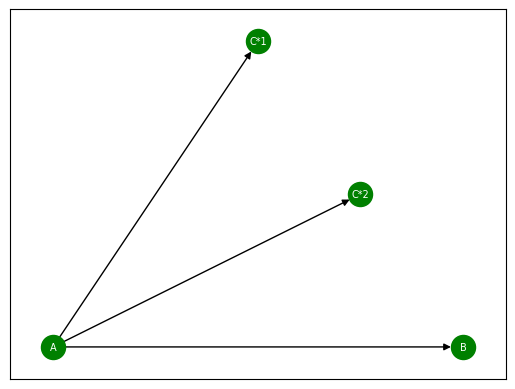

In [ ]:
p = _create_graph(['A', 'B', 'C*1', 'C*2'], [('A','B'), ('A','C*1'), ('A', 'C*2')])
_plot_graph(p)
_assert_rule(lhs, p=p, nodes_clone={'C': {'C*1', 'C*2'}})

We can clone different nodes simultaniously, and new edges will be created accordingly (including edges that are between two clones of different nodes). Here we clone $A$ for 3 times (including the P node $A$) and $B$ for 2 times (same); Since LHS contains the edge $(A,B)$, we create here completely new edges such as $(A*5, B*9)$. Note that as explained, the copy number (the $5$ in $A*5$) must be a number but the library does not check that it is a valid clone number:

In [ ]:
p = _create_graph(['A', 'B', 'A*3', 'A*5', 'C', 'B*9'], 
                  [('A','B'), ('A', 'B*9'), ('A*3', 'B'), ('A*3', 'B*9'), ('A*5', 'B'), ('A*5', 'B*9'), 
                   ('A', 'C'), ('A*3', 'C'), ('A*5', 'C')])
_assert_rule(lhs, p=p, nodes_clone={'A': {'A', 'A*5', 'A*3'}, 'B': {'B*9', 'B'}})

Cloning can be combined with other operations. For example, clone $A$ and $B$ (both are cloned 2 times) and remove node $C$ (which is not a clone of anything, and therefore is counted as a removed node). Note that in the transformation module, the cloning is done before the nodes removal:

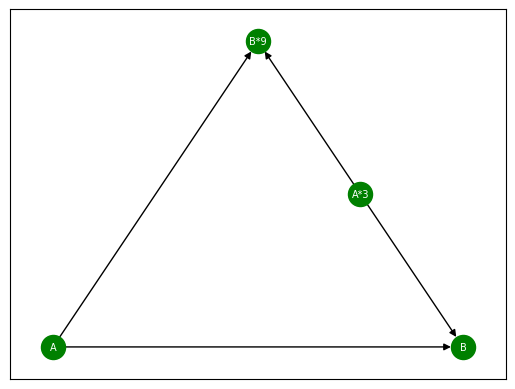

In [ ]:
p = _create_graph(['A', 'B', 'A*3', 'B*9'], 
                  [('A','B'), ('A', 'B*9'), ('A*3', 'B'), ('A*3', 'B*9')])
_plot_graph(p)
_assert_rule(lhs, p=p, nodes_clone={'A': {'A', 'A*3'}, 'B': {'B*9', 'B'}}, nodes_remove={'C'})

As explained above, when cloning a node, all of its edges are cloned as well. Therefore, if we construct P with a clone but do not mention all of the edges that should be created by the clone, the rule will consider the missing edges as removed edges. Here, for example, we clone $C$ but exclude cloning the $(A,C)$ edge for clone $C*1$:

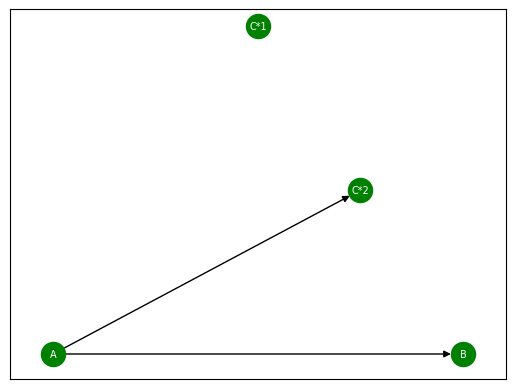

In [ ]:
p = _create_graph(['A', 'B', 'C*1', 'C*2'], [('A','B'), ('A', 'C*2')])
_plot_graph(p)
_assert_rule(lhs, p=p, nodes_clone={'C': {'C*1', 'C*2'}}, edges_remove={('A','C*1')})

#### Preserve, Remove and Clone (With Attributes)

Our graphs might have attributes, and so - we might want to apply what we've covered so far (preserving, removing and cloning) to handle attributes as well. We begin by initializing an LHS pattern with some attributes (note that the attributes are not plotted):

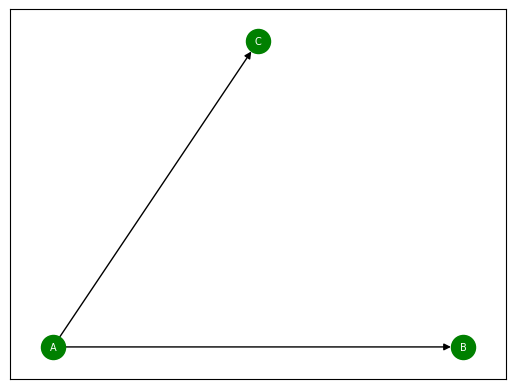

In [ ]:
lhs = _create_graph(['A', ('B', {'attr_b': 5}), 'C'], [('A','B'), ('A','C', {'attr_ac': 10})])

_plot_graph(lhs)

Say that we want to remove a LHS node / edge which has attributes. Just as the removal of a node automatically removed its connected edges without marking these edges as removed - The removal of a node / edge automatically removes its attributes with it, and the rule does not count these attributes as removed attributes. 

In these examples, we remove node $B$ / edge $(A,C)$, both have attributes in LHS:

In [ ]:
p = _create_graph(['A', 'C'], [('A','C', {'attr_ac': 10})])
_assert_rule(lhs, p=p, nodes_remove={'B'})
p = _create_graph(['A', ('B', {'attr_b': 5}), 'C'], [('A','B')])
_assert_rule(lhs, p=p, edges_remove={('A','C')})

We can also remove attributes manualy, while keeping the containing node / edge. Just as in order to remove an LHS node we didn't mention it in P, we can remove a LHS attribute by not mentioning it in P. Here, we remove the attribute "attr_b" from $B$. The rule builds a dictionary that maps nodes to the names of the attributes removed from them:

In [ ]:
p = _create_graph(['A', 'B', 'C'], [('A','B'), ('A','C', {'attr_ac': 10})])
_assert_rule(lhs, p=p, node_attrs_remove={'B': {'attr_b'}})

If we clone a node with attributes, or a node that's connected to edges with attributes (as you well remember, edges connected to a cloned node are cloned as well), the attributes are cloned along with it - both attribute names and values.

In our library, cloning a node / edge with attributes causes a clone of **all** of the contained attributes, and the user **is not able** to choose which of the attributes should be cloned. In order to avoid ambiguity, when constructing a P graph that clones a node / edge with attributes, for each of the clones, **the attributes should not be mentioned in P** (they will all be cloned automatically). A violation of this constraint will cause the Rule class to raise an exception:

In [ ]:
p = _create_graph(['A', 'B', 'C', ('B*1', {'attr_b': 5})],
                  [('A','B'), ('A','B*1'), ('A','C', {'attr_ac': 10})])
_assert_rule(lhs, p=p, error=exceptions["attrs_in_cloned_node"]("B*1"))

p = _create_graph(['A', 'B', 'C', 'C*1'],
                  [('A','B'), ('A','B*1'), ('A','C*1', {'attr_ac': 10})])
_assert_rule(lhs, p=p, error=exceptions["attrs_in_cloned_edge"]("A", "C*1"))

Here, we clone node $B$ as P nodes $B, B*1$ along with its attribute ```{attr_b: 5}```. Note how we do not mention the attributes of either $B, B*1$, and let the transformation module clone them by itself. The rule does not count these automatically-cloned attributes as added attributes:

In [ ]:
p = _create_graph(['A', 'B', 'C', 'B*1'],
                  [('A','B'), ('A','B*1'), ('A','C', {'attr_ac': 10})])
_assert_rule(lhs, p=p, nodes_clone={'B': {'B', 'B*1'}})

#### Addition

We saw how we can use P to denote preservation, removal and cloning - with or without attributes - of LHS nodes. Up until now, RHS defaulted to a copy of P, denoting that we don't want to add anything to the graph. We will now overview the options RHS provides us. Begin by reseting LHS to be our initial, simple pattern without any attributes:

In [ ]:
lhs = _create_graph(['A', 'B', 'C'], [('A','B'), ('A','C')])

Say we want to add a new node to our graph, name it $D$. The rule finds all nodes that appear in RHS but not in P, and marks them as added nodes. Here, P is not specified (and thus default to LHS), and so $D$ is the only new node:

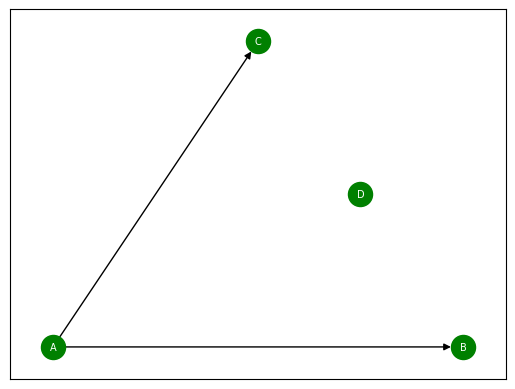

In [ ]:
rhs = _create_graph(['A', 'B', 'C', 'D'], [('A','B'), ('A','C')])
_plot_graph(rhs)
_assert_rule(lhs, rhs=rhs, nodes_add={'D'})

The same can be done with edges. We can add edges that use nodes which existed in P, as we do here with the new edge $(B,C)$:

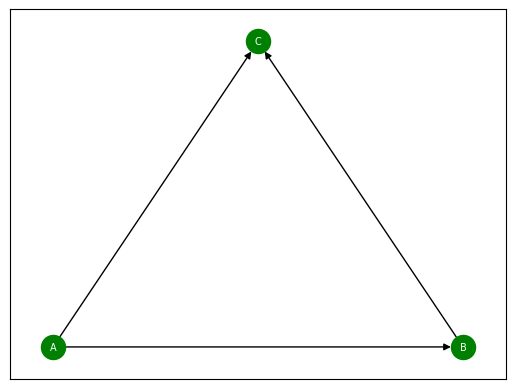

In [ ]:
rhs = _create_graph(['A', 'B', 'C'], [('A','B'), ('A','C'), ('B','C')])
_plot_graph(rhs)
_assert_rule(lhs, rhs=rhs, edges_add={('B','C')})

But we can also combine edges which use the new added nodes. Here, we combine the addition of a new node $D$, a new edge that uses it $(A,D)$ and a new edge that uses only P nodes $(B,C)$:

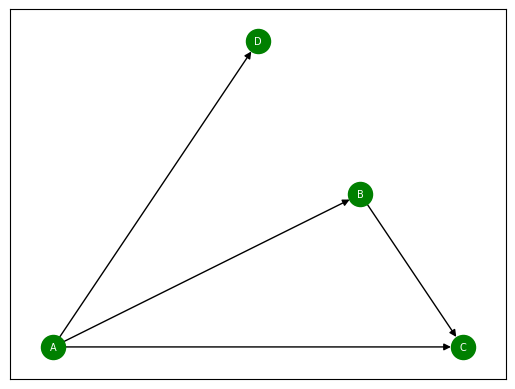

In [ ]:
rhs = _create_graph(['A', 'B', 'C', 'D'], [('A','B'), ('A','D'), ('A','C'), ('B','C')])
_plot_graph(rhs)
_assert_rule(lhs, rhs=rhs, nodes_add={'D'}, edges_add={('B','C'), ('A','D')})

The use of attributes in addition is very intuitive: Attributes that appear in RHS but not in P are considered as added attributes, including all attributes of any new node (excluding merges; we'll get to that shortly). 

For example, assume we update our LHS with an attribute added to edge $(A,C)$:

In [ ]:
lhs = _create_graph(['A', 'B', 'C'], [('A','B'), ('A','C', {'attr_ac': 'ac'})])

If we add a new attribute for existing node $A$, new node $D$, existing edge $(A,B)$ and new edge $(A,D)$:

In [ ]:
rhs = _create_graph([('A', {'attr_a': 'a'}), 'B', 'C', ('D', {'attr_d': 'd'})],
                    [('A','B', {'attr_ab': 'ab'}), ('A','D', {'attr_ad': 'ad'}), ('A','C', {'attr_ac': 'ac'}), ('B','C')])
_assert_rule(lhs, rhs=rhs, nodes_add={'D'}, edges_add={('A','D'), ('B','C')},
             node_attrs_add={'A': {'attr_a': 'a'}, 'D': {'attr_d': 'd'}},
             edge_attrs_add={('A','B'): {'attr_ab': 'ab'}, ('A','D'): {'attr_ad': 'ad'}})

#### Merge Nodes

As explained in the beginning of this notebook, the combination of P and RHS allows **merging** nodes.

Assume that P contains nodes $x_1,...,x_k$, and that we want to **replace** them all with a single, merged node - merges all of their attributes and edges. In the RHS graph, we add a new node called $x_1 \& x_2 \& ... \& x_k$. A RHS node with such a name is automatically inferred to be a merge of the P nodes $x_1,...,x_k$ (if any of them does not exist in P, an exception is raised), and the transformation module will handle the merging of the edges and attributes as expected.

The Rule class identifies RHS nodes that are merges of P nodes, and creates a dictionary that maps RHS nodes to a set of P nodes which they merge (if there are any). The edges and attributes that are added by the merging are not counted as added edges and attributes; The nodes, edges and attributes that were removed (merged into the new node) are not marked as removed; The merged node is not counted as an added node, but rather as a merged one.

For the basic, attribute-less examples, we return to our basic LHS (Which will also serve as P here):

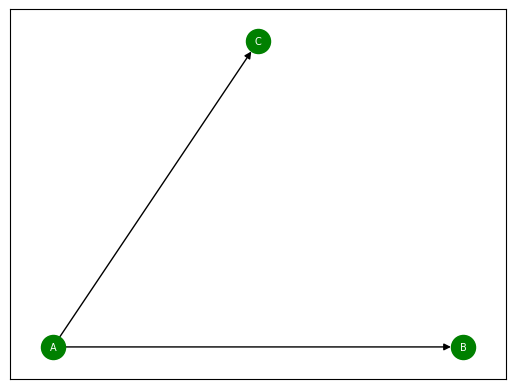

In [ ]:
lhs = _create_graph(['A', 'B', 'C'], [('A','B'), ('A','C')])
_plot_graph(lhs)

We begin with a simple example, where we want to merge nodes $B$ and $C$ into a new node called $B\&C$. Note that in the resulting RHS graph, $B$ and $C$ do not exist anymore, and so are the connected edges $(A,B),(B,C)$. They were replace by the new merged node, and a new edge $(A,B\&C)$ which merges the two original edges. Although we removed and added different edges and nodes here, none of them are marked as added or removed by the rule:

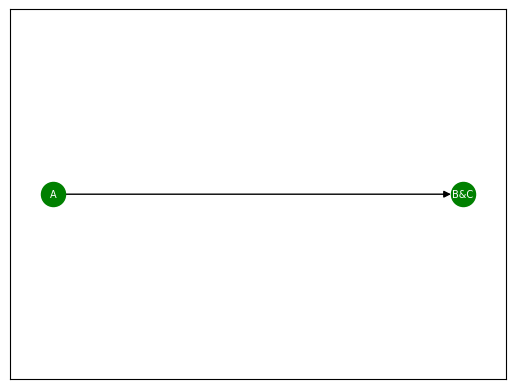

In [ ]:
rhs = _create_graph(['A', 'B&C'], [('A','B&C')])
_plot_graph(rhs)
_assert_rule(lhs, rhs=rhs, nodes_merge={'B&C': {'B','C'}})

If we merge nodes $A, B$, then the original edge $(A,B)$ is now replaced by $(A\&B, A\&B)$ - that is, a self loop:

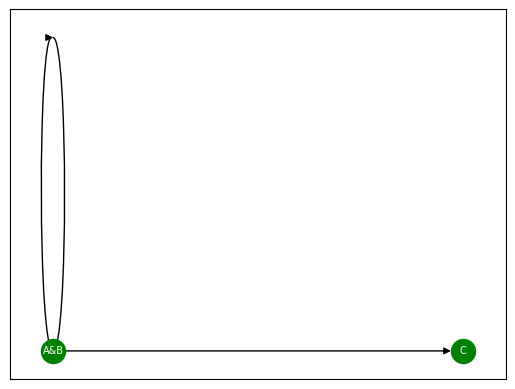

In [ ]:
# Merge node A and B
rhs = _create_graph(['A&B', 'C'], [('A&B','A&B'), ('A&B', 'C')])
_plot_graph(rhs)
_assert_rule(lhs, rhs=rhs, nodes_merge={'A&B': {'A','B'}})

We can merge more than two nodes into a new one. Here we do so with all three nodes in P, resulting in a single node with a self loop:

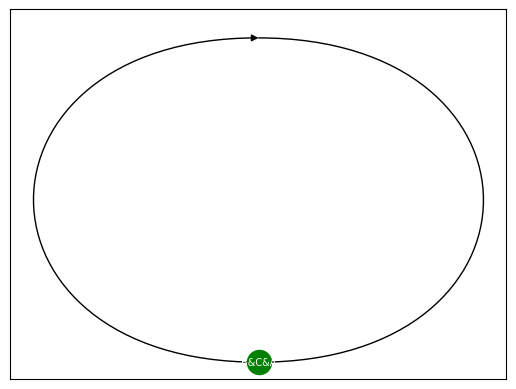

In [ ]:
# Merge node A, B and C
rhs = _create_graph(['B&C&A'], [('B&C&A', 'B&C&A')])
_plot_graph(rhs)
_assert_rule(lhs, rhs=rhs, nodes_merge={'B&C&A': {'A','B','C'}})

Let's see how attributes behave when merging nodes and edges which contain them.

In our library, merging a node / edge with attributes causes a merge of **all** of the contained attributes, similarily to the cloning process. Therefore, when merging, the merged node **should not mention the merged attributes** (automatically they will all be merged and added).

Begin with a simple case: Given the basic LHS with some attributes:

In [ ]:
lhs = _create_graph([('A', {'attr': 1}), 'B', 'C'], [('A','B', {'attr_ab': 'ab'}), ('A','C')])

We merge nodes $A,B$, where $A$ has a single attribute and $B$ has no attributes. Therefore, we expect the merged $A\&B$ node to have this single attribute with the same value. Note that similarily to the behaviour of attributes in cloned nodes, the attributes added to the merged node by the merging process are not marked as added (and are not mentioned at all, as explained above):

In [ ]:
rhs = _create_graph(['A&B', 'C'], [('A&B','A&B'), ('A&B','C')])
_assert_rule(lhs, rhs=rhs, nodes_merge={'A&B': {'A','B'}})

Unlike cloning, merging **does** allow mentioning attributes in the merged node; The rule will read these attributes as new attributes which are added after the merging.
For example, if we want to add a new attribute to the merged node $A\&B$ after the merging, we do mention it in the RHS and the rule will identify it as an added attribute:

In [ ]:
rhs = _create_graph([('A&B', {'attr2': 2}), 'C'], [('A&B','A&B', {'attr_ab2': 'ab'}), ('A&B','C')])
_assert_rule(lhs, rhs=rhs, nodes_merge={'A&B': {'A','B'}}, node_attrs_add={'A&B': {'attr2': 2}},
             edge_attrs_add={('A&B', 'A&B'): {'attr_ab2': 'ab'}})

When the transformation will be executed, the resulting $A\&B$ node will have both attributes.

What if we want to override one of the merged attributes of $A\&B$? In such a case, we mention the overriding attribute in RHS, and it will be marked as an added attribute.

In [ ]:
rhs = _create_graph([('A&B', {'attr': 5}), 'C'], [('A&B','A&B'), ('A&B','C')])
_assert_rule(lhs, rhs=rhs, nodes_merge={'A&B': {'A','B'}}, node_attrs_add={'A&B': {'attr': 5}})

During transformation, first the merged node will inherit the original value of the attribute; Then, when adding new attributes to RHS, the new value of the attribute will override the old one.

Note that this allows a case where we merge two nodes with an attribute of the same name. What should the value of the attribute be in the merged node? Here's a problematic example case:

In [ ]:
lhs = _create_graph([('A', {'attr': 'a'}), ('B', {'attr': 'b'}), 'C'], [('A','B', {'attr2': 'ab'}), ('A','C', {'attr2': 'ac'})])

Our library provides a few built-in tie breakers, via the static **MergePolicy** Functions. The standard (and default) option is **choose_last**, which just picks the value of the last node in the list of P nodes merged into the new RHS node. A more advanced option, **union**, sets the value of the attribute in the merged node to be a set that contains the attribute values from all different P nodes merged into that RHS node.

Since we check here only rules and not the graphs which they transform, we cannot test the merge policy here. Instead, it will be checked in the transform module.

#### Combine it all

We will now do some a few last tests, using multiple abilities of the Rule class, as the user will do with this library:

For the following LHS:

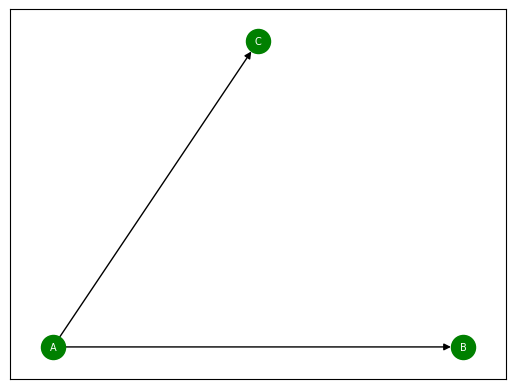

In [ ]:
lhs = _create_graph(['A', ('B', {'attr': 'b', 'attr2': 'b2'}), 'C'], [('A','B'), ('A','C')])
_plot_graph(lhs)

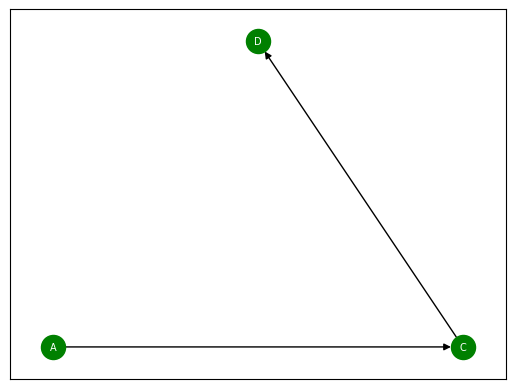

In [ ]:
# Remove node B (with edges and attributes), add node D and connect it to C
p = _create_graph(['A', 'C'], [('A', 'C')])
rhs = _create_graph(['A', 'C', 'D'], [('A', 'C'), ('C', 'D')])
_plot_graph(rhs)
_assert_rule(lhs, p=p, rhs=rhs, nodes_remove={'B'}, nodes_add={'D'}, edges_add={('C','D')})

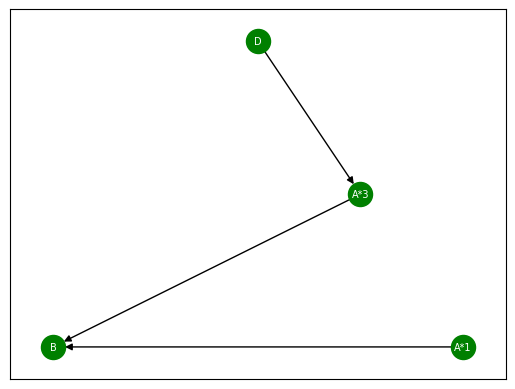

In [ ]:
# Remove node C (with edges), remove attribute 'attr' from B, clone A two times,
# add node D, connect one of the clones to D, add attribute 'attr3' to B
p = _create_graph([('B', {'attr2': 'b2'}), 'A*1', 'A*3'], [('A*1','B'), ('A*3','B')])
rhs = _create_graph([('B', {'attr2': 'b2', 'attr3': 'b3'}), 'A*1', 'A*3', 'D'], [('A*1','B'), ('A*3','B'), ('D', 'A*3')])
_plot_graph(rhs)
_assert_rule(lhs, p=p, rhs=rhs, nodes_remove={'C'}, node_attrs_remove={'B': {'attr'}}, nodes_clone={'A': {'A*1', 'A*3'}},
             nodes_add={'D'}, edges_add={('D','A*3')}, node_attrs_add={'B': {'attr3': 'b3'}})

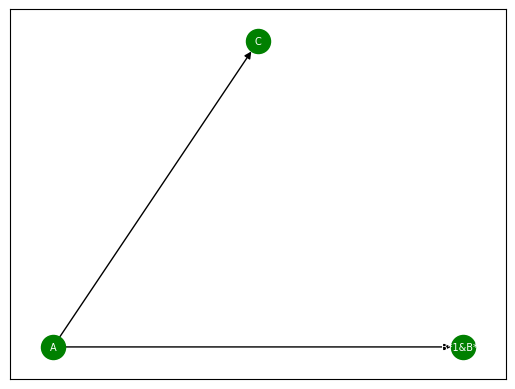

In [ ]:
# Clone a node B, just to merge its clones back later
p = _create_graph(['A', 'B*1', 'B*2', 'C'], [('A','B*1'), ('A', 'B*2'), ('A','C')])
rhs = _create_graph(['A', 'B*1&B*2', 'C'], [('A', 'B*1&B*2'), ('A', 'C')])
_plot_graph(rhs)
_assert_rule(lhs, p=p, rhs=rhs, nodes_clone={'B': {'B*1', 'B*2'}}, nodes_merge={'B*1&B*2': {'B*1', 'B*2'}})

More integration testing will be done in the Transform module.